In [63]:
import torch
from torchvision import datasets, transforms

# Transform pipeline:
# - ToTensor: Converts image to torch tensor (shape: [1, 28, 28]), values scaled to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load training and test datasets
train_dataset = datasets.MNIST(
    root='./data',       # Where to store the data
    train=True,          # Load training data
    transform=transform, # Apply our transform (to tensor)
    download=True        # Download if not present
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,         # Load test data
    transform=transform,
    download=True
)

# Wrap datasets into dataloaders for batch processing
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=64,       # Train with 64 samples at a time
    shuffle=True         # Shuffle during training
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False        # No need to shuffle during testing
)


In PyTorch, DataLoader is a helper class that:

- Wraps a dataset (like MNIST)

- Allows you to iterate over it in batches

- Automatically shuffles, loads, and preprocesses data



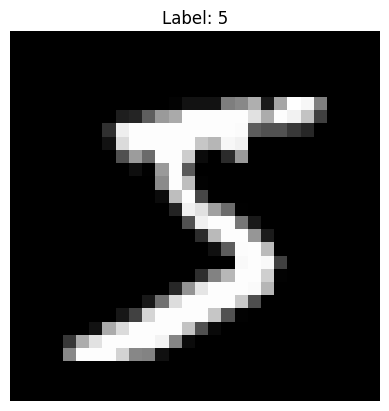

In [64]:
import matplotlib.pyplot as plt

# Pick the first sample from training dataset
sample_img, label = train_dataset[0]

# sample_img has shape [1, 28, 28] — remove channel dimension using .squeeze()
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


In [65]:

def poisson_encode(images, time_steps):
    """
    Convert static images into spike trains using Poisson rate encoding.

    Parameters:
        images (torch.Tensor): Shape (batch_size, 1, 28, 28), normalized to [0, 1]
        time_steps (int): Number of time steps for simulation

    Returns:
        spike_trains (torch.Tensor): Shape (time_steps, batch_size, 784), binary spikes
    """

    batch_size = images.size(0)

    # Flatten images from (batch_size, 1, 28, 28) to (batch_size, 784)
    flattened_images = images.view(batch_size, -1)

    # Expand to shape (time_steps, batch_size, 784)
    # For each timestep, we generate a new spike sample
    repeated_images = flattened_images.unsqueeze(0).repeat(time_steps, 1, 1)

    # Generate random values of same shape
    random_vals = torch.rand_like(repeated_images)

    # If random value < pixel intensity → spike (1), else 0
    spike_trains = (random_vals < repeated_images).float()

    return spike_trains  # Shape: (T, B, 784)


In [66]:
import matplotlib.pyplot as plt

def plot_spike_raster(spike_train, max_neurons=100):
    """
    spike_train: shape (T, 784), binary spike train for a single image
    """
    # Limit number of neurons to plot
    spike_train = spike_train[:, :max_neurons]  # shape (T, N)

    # Transpose to get spikes in (neuron_id, time_step)
    # spike_train is already (T, N), so we extract spike locations
    spike_times, neuron_ids = spike_train.nonzero(as_tuple=True)

    if len(spike_times) == 0:
        print("No spikes found.")
        return

    plt.figure(figsize=(10, 5))
    plt.scatter(spike_times.cpu(), neuron_ids.cpu(), s=5, color="black")
    plt.title("Poisson Spike Raster Plot")
    plt.xlabel("Time step")
    plt.ylabel("Neuron index")
    plt.ylim(-1, max_neurons)  # ensure axis shows data
    plt.xlim(0, spike_train.shape[0])
    plt.tight_layout()
    plt.show()


Total spikes generated: 10807.0


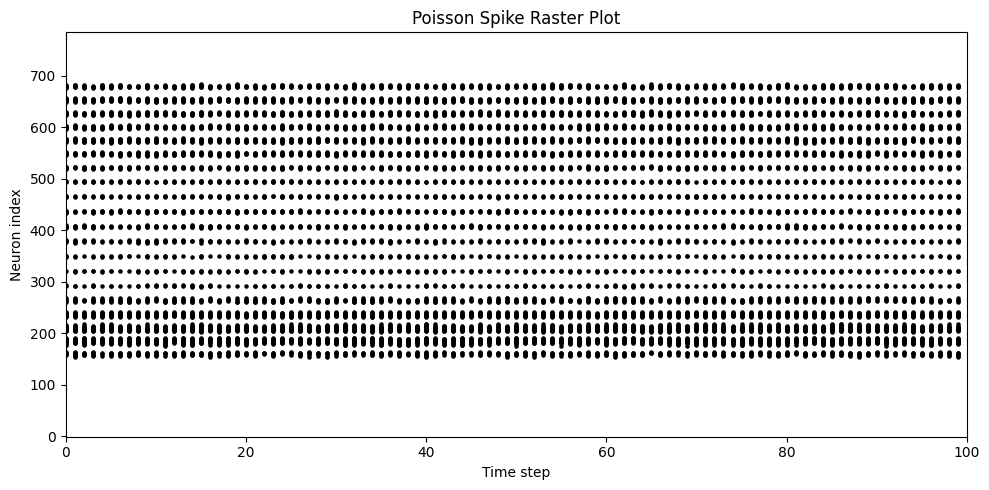

In [67]:
# Get a single image and label
sample_img, label = train_dataset[0]
sample_img = sample_img.unsqueeze(0)  # Add batch dimension → (1, 1, 28, 28)

# Encode to spike train for T=100 steps
spike_train = poisson_encode(sample_img, time_steps=100)  # Shape: (100, 1, 784)
print("Total spikes generated:", spike_train.sum().item())

# Remove batch dimension → shape: (100, 784)
spike_train_single = spike_train.squeeze()
# print(spike_train_single.shape())

# Plot spike raster
plot_spike_raster(spike_train_single, max_neurons=784)


In [68]:
def plot_spike_heatmap(original_img, spike_train, time_steps):
    """
    Plots the original MNIST image alongside the spike activity map.

    Parameters:
        original_img (Tensor): shape (1, 28, 28)
        spike_train (Tensor): shape (T, 784) spike train for that image
        time_steps (int): number of time steps used in encoding
    """

    # Sum over time → get total spikes per pixel
    spike_counts = spike_train.sum(dim=0)  # shape: (784,)
    spike_map = spike_counts.view(28, 28)  # reshape to image grid

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Original image
    axes[0].imshow(original_img.squeeze(), cmap='gray')
    axes[0].set_title("Original MNIST Digit")
    axes[0].axis('off')

    # Spike heatmap
    im = axes[1].imshow(spike_map, cmap='hot', interpolation='nearest')
    axes[1].set_title(f"Spike Activity over {time_steps} steps")
    axes[1].axis('off')

    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


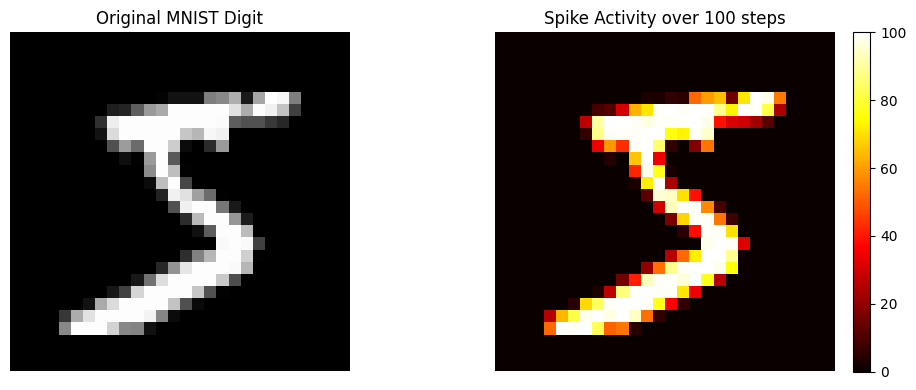

In [69]:
# Load a sample image
sample_img, label = train_dataset[0]
sample_img = sample_img.unsqueeze(0)  # shape: (1, 1, 28, 28)

# Encode to spike train
T = 100
spike_train = poisson_encode(sample_img, time_steps=T)  # shape: (T, 1, 784)

# Remove batch dim → (T, 784)
spike_train_single = spike_train[:, 0, :]

# Plot
plot_spike_heatmap(sample_img[0], spike_train_single, T)


In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LIFNeuron(nn.Module):
    def __init__(self, num_neurons, tau=10.0, v_th=1.0, v_reset=0.0):
        super(LIFNeuron, self).__init__()
        self.num_neurons = num_neurons
        self.tau = tau
        self.v_th = v_th
        self.v_reset = v_reset

        self.register_buffer("membrane_potential", None)

        # Precompute decay constant alpha
        self.alpha = torch.exp(torch.tensor(-1.0 / tau))

    def reset_state(self, batch_size):
        """
        Resets membrane potential to zero at the start of each new input sequence.
        """
        self.membrane_potential = torch.zeros(batch_size, self.num_neurons)

    def forward(self, input_current):
        """
        Runs one time step of LIF dynamics.
        input_current: Tensor of shape (batch_size, num_neurons)
        Returns:
            output_spikes: Binary tensor (batch_size, num_neurons)
        """
        # Leak and integrate
        self.membrane_potential = self.alpha * self.membrane_potential + (1 - self.alpha) * input_current

        # Generate spikes
        # output_spikes = (self.membrane_potential >= self.v_th).float()
        output_spikes = SurrogateSpike.apply(self.membrane_potential, self.v_th)


        # Reset potential for spiked neurons
        self.membrane_potential = self.membrane_potential * (1 - output_spikes) + self.v_reset * output_spikes

        return output_spikes

class SNNLayer(nn.Module):
    def __init__(self, input_size, output_size, tau=2.0, v_th=1.0, v_reset=0.0):
        super(SNNLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size, bias=False)  # synaptic weights
        self.lif = LIFNeuron(output_size, tau=tau, v_th=v_th, v_reset=v_reset)

    def reset_state(self, batch_size):
        """
        Resets LIF neuron state for a new input sequence.
        """
        self.lif.reset_state(batch_size)

    def forward(self, spike_input):
        """
        spike_input: Tensor of shape (batch_size, input_size)
        Returns:
            output_spikes: Tensor of shape (batch_size, output_size)
        """
        # Apply synaptic weights
        input_current = self.fc(spike_input)

        # Pass through LIF neurons
        output_spikes = self.lif(input_current)
        return output_spikes

class SurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, threshold):
        ctx.save_for_backward(input)
        return (input >= threshold).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # Fast sigmoid surrogate: gradient = 1 / (1 + |x|)^2
        grad_input = grad_output.clone()
        surrogate_grad = 1.0 / (1.0 + torch.abs(input)) ** 2
        return grad_input * surrogate_grad, None  # second None for threshold (not learnable)




class SNNModel(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, output_size=10, tau=2.0, v_th=1.0):
        super(SNNModel, self).__init__()

        self.layer1 = SNNLayer(input_size, hidden_size, tau=tau, v_th=v_th)
        self.layer2 = SNNLayer(hidden_size, output_size, tau=tau, v_th=v_th)

    def reset_state(self, batch_size):
        self.layer1.reset_state(batch_size)
        self.layer2.reset_state(batch_size)

    def forward(self, input_spike_train):
        """
        input_spike_train: shape (T, B, 784)
        Returns:
            output_spike_counts: shape (B, 10)
        """
        T, B, _ = input_spike_train.shape
        output_spike_counts = torch.zeros(B, 10, device=input_spike_train.device)

        for t in range(T):
            x = input_spike_train[t]                # shape: (B, 784)
            x = self.layer1(x)                      # shape: (B, hidden)
            x = self.layer2(x)                      # shape: (B, 10)
            output_spike_counts += x                # accumulate output spikes

        return output_spike_counts



In [71]:
import torch.optim as optim

def train(model, train_loader, test_loader, num_epochs=10, time_steps=100, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            batch_size = imgs.size(0)

            # 1. Poisson encoding
            spike_input = poisson_encode(imgs, time_steps).to(device)  # shape: (T, B, 784)

            # 2. Reset model neuron states
            model.reset_state(batch_size)

            # 3. Forward pass over time
            output_spike_counts = model(spike_input)  # shape: (B, 10)

            # 4. Compute loss
            loss = criterion(output_spike_counts, labels)

            # 5. Backprop and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_size
            pred = output_spike_counts.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += batch_size

        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss/total:.4f} | Train Accuracy: {accuracy:.2f}%")

        # Evaluate on test set after each epoch
        evaluate(model, test_loader, time_steps, device)

def evaluate(model, dataloader, time_steps=100, device='cuda'):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            batch_size = imgs.size(0)

            spike_input = poisson_encode(imgs, time_steps).to(device)
            model.reset_state(batch_size)
            output_spike_counts = model(spike_input)

            pred = output_spike_counts.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += batch_size

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy



In [77]:
model = SNNModel(input_size=784, hidden_size=128, output_size=10, tau=2.0, v_th=1.0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
time_steps = 10
num_epochs = 10
# ----- Step 4: Train -----
train(model, train_loader, test_loader, num_epochs=num_epochs, time_steps=time_steps, device=device)


Epoch 1/10 | Loss: 0.8529 | Train Accuracy: 72.47%
Test Accuracy: 86.93%
Epoch 2/10 | Loss: 0.4129 | Train Accuracy: 87.76%
Test Accuracy: 89.06%
Epoch 3/10 | Loss: 0.3338 | Train Accuracy: 89.39%
Test Accuracy: 90.53%
Epoch 4/10 | Loss: 0.2788 | Train Accuracy: 90.97%
Test Accuracy: 91.56%
Epoch 5/10 | Loss: 0.2386 | Train Accuracy: 92.21%
Test Accuracy: 93.05%
Epoch 6/10 | Loss: 0.2072 | Train Accuracy: 93.29%
Test Accuracy: 93.61%
Epoch 7/10 | Loss: 0.1808 | Train Accuracy: 94.19%
Test Accuracy: 94.37%
Epoch 8/10 | Loss: 0.1638 | Train Accuracy: 94.83%
Test Accuracy: 94.52%
Epoch 9/10 | Loss: 0.1494 | Train Accuracy: 95.28%
Test Accuracy: 95.15%
Epoch 10/10 | Loss: 0.1362 | Train Accuracy: 95.67%
Test Accuracy: 95.24%
